In [28]:

import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp
from genpen.utils import Paper
from scipy import stats
import geopandas
from shapely.errors import TopologicalError
import functools
import vpype
from skimage import io
from pathlib import Path

from sklearn.preprocessing import minmax_scale
from skimage import feature
from skimage import exposure

from skimage import filters
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import disk
from numpy.random import default_rng

def local_angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

from PIL import Image
from scipy import stats

import cv2
from rasterio import features
import rasterio
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
image_path= '/home/naka/art/raster_images/blood_red_sunset.png'
image_path = '/home/naka/art/vqgan_clip/sensuality.png'
paper_size:str = '14x11 inches'
border:float=25  # mm
image_rescale_factor:float=0.25
smooth_disk_size:int=2
hist_clip_limit=0.1
hist_nbins=22
intensity_min=0.05
intensity_max=1.
hatch_spacing_min=0.3  # mm
hatch_spacing_max=1.2  # mm
pixel_width=1  # mm
pixel_height=1  # mm
angle_jitter='stats.norm(scale=0).rvs'  # degrees
# angle_jitter='0'
pixel_rotation='0'  # degrees
merge_tolerances=[0.1, 0.2, 0.3]  # mm
simplify_tolerances=[0.05, 0.1, ]  # mm
savedir='/home/naka/art/plotter_svgs'

In [204]:
# make page
paper = Paper(paper_size)
drawbox = paper.get_drawbox(border)

# load
img =  rgb2gray(io.imread(Path(image_path)))
img_rescale = np.clip(rescale(img, image_rescale_factor), 0, 1)

img_renorm = exposure.equalize_adapthist(img_rescale, clip_limit=hist_clip_limit, nbins=hist_nbins)
img_renorm = img_rescale

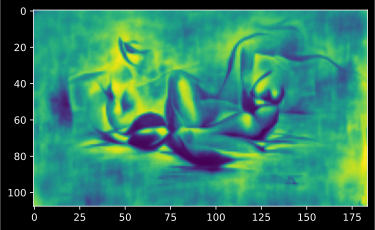

In [205]:
plt.imshow(img_renorm)

In [206]:
# calc dominant angle
selem = disk(smooth_disk_size)
filt_img = filters.rank.mean(img_renorm, selem)
angle_farid = local_angle(filters.farid_h(filt_img), filters.farid_v(filt_img))

# make pixel polys
prms = []
for y, row in tqdm(enumerate(img_renorm)):
    for x, intensity in enumerate(row):

        p = gp.centered_box(Point(x, y), width=pixel_width, height=pixel_height)
        a = np.degrees(angle_farid[y, x])
        prm = {
            'geometry':p,
            'x':x,
            'y':y,
            'raw_pixel_width':pixel_width,
            'raw_pixel_height':pixel_height,
            'intensity': intensity,
            'angle':a,
            'group': 'raw_hatch_pixel',

        }
        prms.append(prm)
raw_hatch_pixels = geopandas.GeoDataFrame(prms)

/home/naka/anaconda3/envs/genpen/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)
108it [00:00, 145.25it/s]


In [207]:
#  rescale polys to fit in drawbox
bbox = box(*raw_hatch_pixels.total_bounds)
_, transform = gp.make_like(bbox, drawbox, return_transform=True)
A = gp.AffineMatrix(**transform)
scaled_hatch_pixels = raw_hatch_pixels.copy()
scaled_hatch_pixels['geometry'] = scaled_hatch_pixels.affine_transform(A.A_flat)

In [208]:
example_height = gp.get_height(scaled_hatch_pixels.loc[0, 'geometry'])
example_width = gp.get_width(scaled_hatch_pixels.loc[0, 'geometry'])
print(f'pixel size = {example_width:.2}x{example_height:.2}mm')
scaled_hatch_pixels['scaled_pixel_height'] = example_height
scaled_hatch_pixels['scaled_pixel_width'] = example_width

pixel size = 1.7x1.7mm


In [209]:
scaled_hatch_pixels['scaled_pixel_min_dim'] = scaled_hatch_pixels.loc[:, ['scaled_pixel_height', 'scaled_pixel_width']].min(axis=1)

In [210]:
# distributions etc
pixel_rotation_gen = gp.make_callable(eval(pixel_rotation))

scaled_hatch_pixels['pixel_rotation'] = pixel_rotation_gen(len(scaled_hatch_pixels))

In [211]:
intensity_min = 0.
intensity_max = 1

In [212]:
hatch_spacing_min = 0.2

In [213]:
hatch_spacing_max = 2.5

In [233]:
spacing_func = functools.partial(np.interp, xp=[intensity_min, intensity_max], fp=[hatch_spacing_max, hatch_spacing_min, ])
scaled_hatch_pixels['spacing'] = 1.5

In [234]:
angle_min = 0
angle_max = 90

In [235]:
angle_func = functools.partial(np.interp, xp=[intensity_min, intensity_max], fp=[angle_min, angle_max])
scaled_hatch_pixels['hatch_angle'] = scaled_hatch_pixels['intensity'].apply(angle_func)

In [236]:
scaled_hatch_pixels['hatch_angle'] // 30 * 30

0         0.0
1        30.0
2        30.0
3        30.0
4        30.0
         ... 
19867    30.0
19868    30.0
19869    60.0
19870    60.0
19871    60.0
Name: hatch_angle, Length: 19872, dtype: float64

In [237]:
filt_scaled_hatch_pixels = scaled_hatch_pixels.query('spacing < scaled_pixel_min_dim')

In [238]:
new_rows = []
for i, row in tqdm(filt_scaled_hatch_pixels.iterrows(), total=len(filt_scaled_hatch_pixels)):
    r = row.copy()
    p = r['geometry']
    if abs(r['pixel_rotation']) > np.finfo(float).eps:
        p = sa.rotate(p, r['pixel_rotation'])
    f = gp.hatchbox(p, spacing=r['spacing'], angle=r['hatch_angle'])
    r['geometry'] = f
    new_rows.append(r)

fills = geopandas.GeoDataFrame(new_rows)
fills = fills[fills.length > 0]
fill_layer = gp.merge_LineStrings(fills.geometry)

100%|██████████| 19872/19872 [00:05<00:00, 3599.42it/s]


In [239]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.stroke(1)
sk.geometry(fill_layer)
sk.display()

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-11-09T20:10:55.662535 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

In [245]:
merge_tolerances=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5,] # mm
# simplify_tolerances=[0.05, 0.1,] # mm

In [246]:
for tolerance in merge_tolerances:
    sk.vpype(f'linemerge --tolerance {tolerance}mm')

for tolerance in simplify_tolerances:
    sk.vpype(f'linesimplify --tolerance {tolerance}mm')
sk.display()

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-11-09T20:11:31.578169 
 
 
 
 
 
 
 <polyline points="200.2489,295.7398 196.0597,289.4625 194.3506,289.4625 189.4034,283.1852 188.2479,283.1852 182.9515,276.9079 182.1149,276.9079 176.5299,270.6306 175.7489,270.6306 170.3413,264.3533 169.7008,264.3533 163.8348,258.076 163.2709,258.076 157.7101,251.7987 156.8415,251.7987 151.5849,245.5214 150.397,245.5214 145.4747,239.2441 144.3133,239.2441 139.0038,232.9668 138.1915,232.9668 126.3341,220.4122 125.4493,220.4122 120.2041,214.1349 119.1946,214.1349 113.9041,207.8576 107.1334,201.5892 107.1334,200.6588 100.8561,196.2244"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="583.7269,866.9743 578.4126,860.697 546.5446,829.6384 546.5446,828.9996 540.2673,823.3441 540.2673,822.632 533.99,817.1571 509.0747,791.6467 508.3678,791.6467 503.1164,785.3694 502.0426,785.3694 496.8871,779.0921 495.7568,779.0921 490.6183,772.8148 489.3028,772.8148 484.5176,766.5375 482.9567,766.5375 478.3092,760.2602 477.4035,760.2602 471.3077,753.9829 470.734,753.9829 465.4226,747.7056 464.2175,747.7056 459.3845,741.4283 458.1836,741.4283 452.8638,735.151 439.8304,722.6658 439.1089,722.5964 434.2747,716.3191"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="521.4354,626.3735 515.1581,624.2228 515.1581,626.0877 508.8808,624.5086 508.8808,626.002 502.6035,624.5944 502.6035,625.9729 496.3262,624.6235 496.3262,625.9223 490.0489,624.6741 490.0489,625.9196 483.7716,624.6767 483.7716,625.9556 477.4943,624.6408 477.4943,626.0611 471.217,624.5353 471.217,626.0373 464.9397,624.5591 464.9397,625.984 458.6624,624.6123 458.6624,625.8865 452.385,624.7098 452.385,625.7405 446.1077,624.8559 446.1077,625.7051 439.8304,624.8913 439.8304,625.8058 433.5531,624.7906"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="603.0403,699.5464 609.3176,701.7052 609.3176,700.1315 615.5949,701.1201 615.5949,700.3826 621.8722,700.869 621.8722,700.4528 659.536,700.8226 659.536,700.3981 665.8133,700.8535 665.8133,700.4144 716.0317,700.8207 716.0317,700.379 722.309,700.8726 722.309,700.3669 728.5863,700.8847 728.5863,700.3607 734.8637,700.8909 734.8637,700.2657 741.141,700.9859 741.141,700.1488 747.4183,701.1028 747.4183,700.0912 753.6956,701.1604 753.6956,700.0263 759.9729,701.2254 759.9729,699.9404 766.2502,701.3113 766.2502,699.6992 772.5275,701.5524"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="898.0735,626.0127 891.7962,624.5837 891.7962,625.6195 885.5189,624.9769 885.5189,625.4878 866.687,625.0559 866.687,625.6794 860.4097,624.9169 860.4097,625.8416 854.1324,624.7548 854.1324,626.0866 847.8551,624.5098 847.8551,626.0721 841.5778,624.5243 841.5778,625.9704 835.3005,624.6259 835.3005,625.8955 829.0232,624.7009 829.0232,625.7794 822.7459,624.817 822.7459,625.6983 816.4686,624.8981 816.4686,625.6836 810.1913,624.9128 810.1913,625.6949 803.914,624.9015 803.914,625.6918 797.6367,624.9046 797.6367,625.6934 791.3594,624.903 791.3594,625.6952 785.0821,624.9012 785.0821,625.809 778.8048,624.7874 778.8048,625.9829 772.5275,624.6135 772.5275,626.2803 766.2502,624.3161"/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <polyline points="385.5169,264.3533 387.4299,270.6306 385.6147,270.6306 387.3321,276.9079 385.6938,276.9079 387.2529,283.1852 385.6856,283.1852 387.2611,289.4625 385.597,289.4625 387.3497,295.7398 385.5107,295.7398 387

In [247]:
sk.vpype('linesort')

In [248]:
import fn

In [249]:
plot_id = fn.new_plot_id()

saved 20211109-201152_907190-b365a-08ce01 to s3://algorithmic-ink/current_plot_id


In [250]:
savedir='/home/naka/art/plotter_svgs'

In [251]:
savepath = Path(savedir).joinpath(f'{plot_id}.svg').as_posix()
sk.save(savepath)